# Control Kymograph maker
This notebook is for creating control kymographs

In [4]:
import btrack
print("version no.:", btrack.__version__)
from btrack.utils import import_HDF, import_JSON
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import timeit ## can remove after assessing speed of different methods
from tqdm import tqdm

version no.: 0.4.0


In [3]:
def euclidean_distance(target_track, other_track, frame):
    try:
        idx0 = target_track.t.index(find_apoptosis_time(target_track, index = False)) ## could also do just ## apop_index
        idx1 = other_track.t.index(frame) ## t.index provides the index of that frame
    except:
        return np.inf
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def euc_dist(target_track, other_track, frame, apop_index):
    try:
        idx0 = apop_index ##target_track.t.index(apop_time) ## could also do just ## apop_index
        idx1 = other_track.t.index(frame) ## t.index provides the index of that frame
    except:
        return np.inf
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def euc_dist_mito(target_track, other_track, apop_index):
    idx0 = apop_index ##target_track.t.index(apop_time) ## could also do just ## apop_index
    idx1 = -1 ## t[-1] is the final frame, ie the frame of mitosis
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def find_apoptosis_time(target_track, index): ### if index is set to True then the index of the apoptotic time (wrt target_track) is returned
    for i, j in enumerate(target_track.label):
        if j == 'APOPTOSIS' and target_track.label[i+1] == 'APOPTOSIS' and target_track.label[i+2] == 'APOPTOSIS': # and target_track.label[i+3] =='APOPTOSIS' and target_track.label[i+4] =='APOPTOSIS':
            apop_index = i
            break
    apop_time = target_track.t[apop_index]
    if index == True: 
        return apop_index
    else: 
        return apop_time
    
def kymo_labels(num_bins, label_freq):
    radial_bin = radius / num_bins
    temporal_bin = t_range*2 / num_bins

    ### generate labels for axis PIXELS/FRAMES
    xlocs = range(0, num_bins,label_freq) ## step of 2 to avoid crowding
    xlabels = []
    for m in range(int(-num_bins/2), int(num_bins/2),label_freq):
        xlabels.append(str(int((temporal_bin)*m)) + "," + str(int((temporal_bin)*m+temporal_bin)))

    ylocs = range(0, num_bins, label_freq) ## step of 2 to avoid crowding
    ylabels = []
    for m in range(num_bins, 0, -label_freq):
        ylabels.append(str(int((radial_bin)*m)) + "," + str(int((radial_bin)*(m-1))))
    
    return xlocs, xlabels, ylocs, ylabels

In [2]:
expt_path = '/home/nathan/data/kraken/h2b/giulia/GV0807/'
tracks_fn = os.path.join(expt_path, 'Pos3/Pos3_aligned/HDF/segmented.hdf5')
with btrack.dataio.HDF5FileHandler(tracks_fn, 'r', obj_type = "obj_type_1") as h:
    wt_tracks = h.tracks
with btrack.dataio.HDF5FileHandler(tracks_fn, 'r', obj_type = "obj_type_2") as h:
    scr_tracks = h.tracks
print("Track information loaded")

[INFO][2021/01/19 07:05:32 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/01/19 07:05:32 PM] Loading tracks/obj_type_1
[INFO][2021/01/19 07:05:34 PM] Loading objects/obj_type_1 (408973, 5) (388394 filtered: area>=100)
[INFO][2021/01/19 07:05:37 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/01/19 07:05:37 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/01/19 07:05:37 PM] Loading tracks/obj_type_2
[INFO][2021/01/19 07:05:37 PM] Loading objects/obj_type_2 (12115, 5) (8894 filtered: area>=100)
[INFO][2021/01/19 07:05:37 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded


# to-do:

- [x] check against raw data
- [x] bin into discrete cats, 
- [x] Check for duplicate entries - current method does count cells in every frame
- [x] write script to count only a single incident of specific cell?
- [x] Add labels to bins
- [X] Add mitosis filter
- [ ] Choose range based on micrometers/hours, not pixels/frames
- [x] Write out in suitable format (csv?)
- [x] Iterate over many cells
- [ ] get true apop list
- [ ] sub in new calcs- think about whether thats what i want to measure!
- [ ] Iterate over many experiments
- [x] Speed up calculation beyond 45min for R=400, t=400 (do not calculate euc dist every time, nor find_apop_time


- [x] compare euc_dist to original
- [x] check wts_mito

# Iterating over many cells and calculating kymograph

In [32]:
start = timeit.default_timer()

In [33]:
cumu_wts, cumu_wts_mito = [], [] ## creating empty lists for cumulative 
N_cell = 0
raw_numbers_path = os.path.join(expt_path, 'analysis/raw_numbers')

scr_apops = [scr_track for scr_track in scr_tracks if scr_track.fate.name == 'APOPTOSIS']
for i, scr_apop in tqdm(enumerate(scr_apops)):
    print(i, "/", len(scr_apops))
    target_track = scr_apop
    if len(target_track) < 10: 
        continue
    if target_track.ID in [1,3,4,6,10,11,16,17,18,29]:
        continue
    N_cell += 1
    cell_ID = target_track.ID
    apop_time = find_apoptosis_time(target_track, index = False)
    apop_index = find_apoptosis_time(target_track, index = True)
    radius = 400
    t_range = 200 ### actual range will be twice this as it scans neg and pos
    
    wts = [tuple(((wt_track.ID),
                  (round((euc_dist(target_track, wt_track, (apop_time+delta_t), apop_index)),2)),
                  ((apop_time + delta_t)))) 
           for delta_t in range(-t_range, t_range)
           for wt_track in wt_tracks 
               if euc_dist(target_track, wt_track, apop_time + delta_t, apop_index)<radius
           ]
    
    wts_mito = [tuple(((wt_track.ID),
                  (round((euc_dist_mito(target_track, wt_track, apop_index)),2)),
                  (wt_track.t[-1]),
                  (wt_track.label[-1]),
                  (wt_track.fate.name))) 
           for wt_track in wt_tracks
            if 
            euc_dist_mito(target_track, wt_track, apop_index)<radius and ## within the full radial extent
            wt_track.fate.name == "DIVIDE" 
           ]
    
    ### save out results of scan
    no_wt_fn = os.path.join(raw_numbers_path,('no_wt_Scr_ID_' + str(cell_ID) + '.csv'))
    no_wt_mito_fn = os.path.join(raw_numbers_path, ('no_wt_mito_Scr_ID_' + str(cell_ID) + '.csv'))
    
    with open(no_wt_fn, 'w') as filehandle:
        filehandle.write('%s\n'%'ID, Distance, Frame')
        for listitem in wts:
            filehandle.write('%s\n' % (re.sub(r"[\(\)]", "",str(listitem))))
        
    with open(no_wt_mito_fn, 'w') as filehandle:
        filehandle.write('%s\n'%'ID, Distance, Frame, State, Fate')
        for listitem in wts_mito:
            filehandle.write('%s\n' % (re.sub(r"[\(\)]", "",str(listitem))))
        
    cumu_wts += wts
    cumu_wts_mito += wts_mito

cumu_wts_fn = os.path.join(raw_numbers_path, 'cumu_wts.csv')
cumu_wts_mito_fn = os.path.join(raw_numbers_path, 'cumu_wts_mito.csv')

with open(cumu_wts_fn, 'w') as filehandle:
    filehandle.write('%s\n'%'ID, Distance, Frame')
    for listitem in cumu_wts:
        filehandle.write('%s\n' % (re.sub(r"[\(\)]", "",str(listitem))))
        
with open(cumu_wts_mito_fn, 'w') as filehandle:
    filehandle.write('%s\n'%'ID, Distance, Frame, State, Fate')
    for listitem in cumu_wts_mito:
        filehandle.write('%s\n' % (re.sub(r"[\(\)]", "",str(listitem))))




0it [00:00, ?it/s]

0 / 68
1 / 68
2 / 68
3 / 68
4 / 68
5 / 68
6 / 68
7 / 68
8 / 68
9 / 68
10 / 68
11 / 68
12 / 68





13it [00:44,  3.39s/it]

13 / 68





14it [01:36, 18.18s/it]

14 / 68





15it [02:18, 25.37s/it]

15 / 68





16it [03:07, 32.48s/it]

16 / 68





17it [03:57, 37.50s/it]

17 / 68
18 / 68





19it [04:43, 33.15s/it]

19 / 68
20 / 68





21it [05:28, 30.02s/it]

21 / 68





22it [06:13, 34.57s/it]

22 / 68





23it [06:59, 37.87s/it]

23 / 68
24 / 68
25 / 68





26it [07:44, 31.06s/it]

26 / 68
27 / 68
28 / 68
29 / 68





30it [08:27, 24.96s/it]

30 / 68
31 / 68
32 / 68





33it [09:13, 22.00s/it]

33 / 68
34 / 68
35 / 68
36 / 68





37it [09:55, 18.58s/it]

37 / 68





38it [10:39, 26.09s/it]

38 / 68





39it [11:22, 31.34s/it]

39 / 68





40it [12:08, 35.64s/it]

40 / 68
41 / 68





42it [12:51, 31.39s/it]

42 / 68
43 / 68
44 / 68





45it [13:35, 26.37s/it]

45 / 68





46it [14:16, 30.75s/it]

46 / 68
47 / 68





48it [14:56, 27.63s/it]

48 / 68
49 / 68





50it [15:39, 25.67s/it]

50 / 68
51 / 68





52it [16:19, 24.01s/it]

52 / 68





53it [17:01, 29.51s/it]

53 / 68





54it [17:43, 33.27s/it]

54 / 68
55 / 68





56it [18:24, 29.47s/it]

56 / 68





57it [19:04, 32.50s/it]

57 / 68
58 / 68
59 / 68
60 / 68
61 / 68
62 / 68





63it [19:44, 24.76s/it]

63 / 68





64it [20:25, 29.55s/it]

64 / 68
65 / 68
66 / 68
67 / 68





68it [21:05, 18.61s/it]


In [34]:
stop = timeit.default_timer()

print('Redesigned WT cell counter calculation time: ', round((stop - start),2), 'seconds') 

Redesigned WT cell counter calculation time:  1268.93 seconds


In [ ]:
os.system('spd-say "calculation complete, objective achieved,faster, better, harder,stronger"')

# Plotting data from many Scr events into kymographs

#### Getting xy variables

In [44]:
distance = [cumu_wts[i][1] for i in range(0,len(cumu_wts))]
time = [cumu_wts[i][2] for i in range(0,len(cumu_wts))]

In [45]:
distance_mito = [cumu_wts_mito[i][1] for i in range(0,len(cumu_wts_mito))]
time_mito = [cumu_wts_mito[i][2] for i in range(0,len(cumu_wts_mito))]

#### Choose bin size for labels and to plot data into


In [225]:
## choose bin size 
num_bins = 20

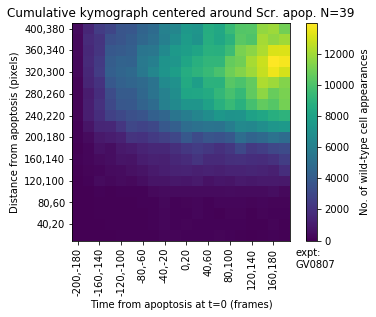

In [75]:
num_bins = 20
H_num_wt, x_autolabels, y_autolabels = np.histogram2d(time, distance, bins=num_bins)
#H = H/bin_size ### because for every bin each cell could be counted for every frame present. Instead of reducing the count down to any instance of a cell, I want to preserve this cumulative count inside a single bin as a measure for how present that cell is in any bin. Ie a cell that is fully present will be counted fully, but only a fleeting presence of 1/20 frames will count as 1/20th of a fully presence. 
xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
plt.xlabel("Time from apoptosis at t=0 (frames)")
plt.ylabel("Distance from apoptosis (pixels)")
title = 'Cumulative kymograph centered around Scr. apop. N=' + str(N_cell)
plt.title(title)
plt.imshow(np.flipud(H_num_wt))
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
plt.colorbar(label = 'No. of wild-type cell appearances')#, ticks = list(range(0, int(round(np.amax(H))),30)))
expt_label = 'expt:\n' + expt_path[36:42]
plt.text(20,22,expt_label)
save_title = 'Cumulative_kymo_no._wt.png'
plt.savefig(os.path.join(expt_path, 'analysis', save_title), bbox_inches = 'tight', dpi = 300)

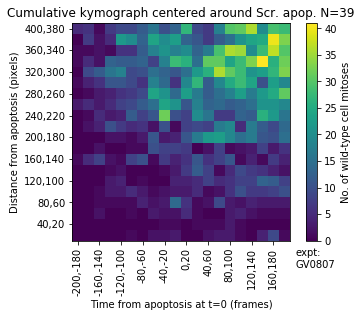

In [77]:
num_bins = 20
H_num_mito, x_autolabels, y_autolabels = np.histogram2d(time_mito, distance_mito, bins=num_bins)
#H_mito = H_mito/bin_size ### because for every bin each cell could be counted for every frame present. Instead of reducing the count down to any instance of a cell, I want to preserve this cumulative count inside a single bin as a measure for how present that cell is in any bin. Ie a cell that is fully present will be counted fully, but only a fleeting presence of 1/20 frames will count as 1/20th of a fully presence. 
xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
plt.xlabel("Time from apoptosis at t=0 (frames)")
plt.ylabel("Distance from apoptosis (pixels)")
title = 'Cumulative kymograph centered around Scr. apop. N=' + str(N_cell)
plt.title(title)
plt.imshow(np.flipud(H_num_mito))
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
plt.colorbar(label = 'No. of wild-type cell mitoses')#, ticks = list(range(0, int(round(np.amax(H_mito))),2)))
expt_label = 'expt:\n' + expt_path[36:42]
plt.text(20,22,expt_label)
save_title = 'Cumulative_kymo_no._wt_mito.png'
plt.savefig(os.path.join(expt_path, 'analysis', save_title), bbox_inches = 'tight', dpi = 300)

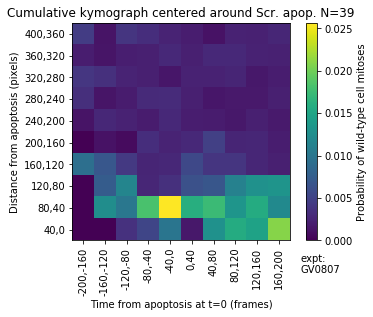

In [80]:
num_bins = 10
H_prob_mito  = np.histogram2d(time_mito, distance_mito, bins=num_bins)[0]/np.histogram2d(time, distance, bins=num_bins)[0]
xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, label_freq = int(num_bins*0.1)) ## 0.1 only adds ten labels to the kymograph
plt.xlabel("Time from apoptosis at t=0 (frames)")
plt.ylabel("Distance from apoptosis (pixels)")
title = 'Cumulative kymograph centered around Scr. apop. N=' + str(N_cell)
plt.title(title)
plt.imshow(np.flipud(H_prob_mito))
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
plt.colorbar(label = 'Probability of wild-type cell mitoses')
expt_label = 'expt:\n' + expt_path[36:42]
plt.text(10,11,expt_label)
save_title = 'Cumulative_kymo_prob_wt_mito.png'
plt.savefig(os.path.join(expt_path, 'analysis', save_title), bbox_inches = 'tight', dpi = 300)